## Preliminary imports

In [ ]:
import matplotlib.pyplot as plt
import sys, numpy as np
import pierce_lab_imaging as im

In [ ]:
im.configure_notebook()

Loading BokehJS ...

## Load the image

In [ ]:
# Either a `czi` or `lif` file may be loaded using the `im.load` function.
lif = im.load('./dHCR-10plex-2023-03-20.lif')
print('Images in lif file =', list(lif))

# In the case of the `lif` files, they contain multiple images so you have to select out the image name
# You can put whatever name you want below. It will be used for the file names of output images
# Note that you must know the dimension ordering and the data type of the image, or else an error will be thrown
# Usually the dimension ordering in Leica is xyl or xylz I believe.
# The data type is either uint8 for 8-bit data or 16-bit otherwise.
img = im.open_lif_series(lif['10plex-rep1_DyeSep001'], 'xylz', np.uint16, name='rep1')

Images in lif file = ['10plex-rep1', 'FrameProperties', '10plex-rep2', '10plex-rep3', '405', '425', '488', '514', '546', '594', '633', '700', '750', '800', 'autofluorescence', '10plex-rep1_DyeSep001', '10plex-rep2_DyeSep001', '10plex-rep3_DyeSep001']


In [ ]:
# Normally the files are assumed to be either xylz or xyl (in any order).
# I use l to signify the wavelength or channel dimension
print('Image dimensions and shape =', img.dims, img.shape)

Image dimensions and shape = ('x', 'y', 'l', 'z') (1024, 256, 11, 43)


In [ ]:
# Dot detection is done for each channel
# For this image we only want the first two channels, so we select with [:2]
channels = img.transpose(*'lxyz')[[3,6], :, :, 24:29].transpose(*'lzxy').astype(np.float32)#.max('z')
#channels = img.transpose(*'lxyz')[[3,6],:,:,1:7].astype(np.float32)

In [ ]:
# There is a lot of plotting functionality. The interactive ones usually start with a blank figure and then draw on top of it
p = im.figure('dark', shape=(700, 700), title='channels')

# Here we can use the following snippet to display an interactive view of the analyzed image
sliders = im.gui.show_xy(p, channels.max('z'))
im.gui.disp(im.gui.column(*sliders, p))

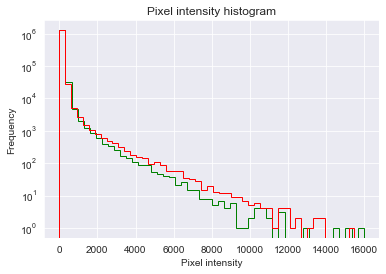

In [ ]:
# Generate pixel intensity histograms. Sometimes it's useful, though many times not.

for c, k in zip(channels, 'gr'):
    plt.hist(c.values.reshape(-1), bins=50, histtype='step', color=k)

# plt.xlim(0, 65535) # you can set the x axis limits like this if desired
plt.title('Pixel intensity histogram')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.yscale('log')
plt.savefig(img.name + ' pixels.pdf')

Run dot detection.

In [ ]:
# Next we'll run dot detection on each image
# The dot detection has some parameters, most of which don't need to be adjusted normally:
help(im.detect_dots)

Help on function detect_dots in module pierce_lab_imaging.dots:

detect_dots(image, max_dots, hi_pass=0.5, sigma=0.2, hi_pass_factor=1, hi_pass_threshold=None, *, limit_radii=None, agglomerate=True, max_maxima=1000000, allow_edges=True, optimize='center', lo_pass=0, gaussian=None, weight_sigma=None, min_ratio=1, dtype=<class 'numpy.float32'>)
    Detect dots in a given image
    
    - `max_dots` (int): maximum number of dots to consider
    - `lo_pass` (float/array): lengthscale less than the dot width (in microns)
    - `hi_pass` (float/array): lengthscale greater than the dot width (in microns)
    - `sigma` (float/array): expected dot width (in microns)
    - `hi_pass_factor` (float): remove features larger than the high pass lengthscale by a factor of this number
    - `hi_pass_threshold` (float): after removing high pass features, zero any pixels below this threshold if given
    - `limit_radii` (float/array): don't detect any candidate dots that are closer than this radius or ra

In [ ]:
# Run the dot detection
results = im.detect_dots(tuple(channels), max_dots=2000, lo_pass=0.0,
    hi_pass=40, sigma=0.3, weight_sigma=0.3, hi_pass_factor=1, agglomerate=False,
    min_ratio=2, optimize='center', max_maxima=int(1e5), allow_edges=True)
#results = [im.detect_dots(c, max_dots=2000, lo_pass=0, hi_pass=40, sigma=0.3, hi_pass_factor=1, limit_radii=0, min_ratio=2, optimize='center') for c in channels]

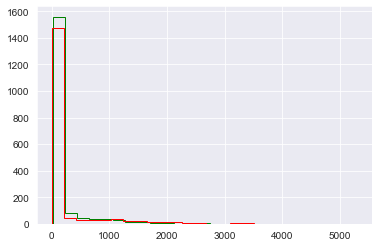

In [ ]:
# results is a list of result dictionaries for each channel. A dictionary contains keys like `centers` and `weights`
# the weights are the dot weights that have been optimized, while the centers are the optimized dot centers
for r, color in zip(results, 'gr'):
    plt.hist(r['weights'], bins=25, histtype='step', color=color);

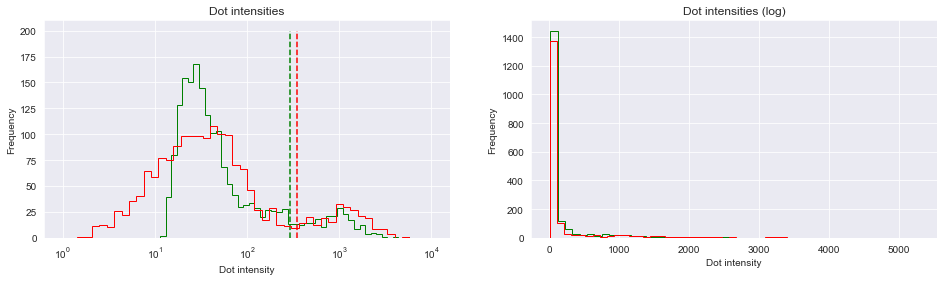

In [ ]:
thresholds = (250,400)
#thresholds = stored_thresholds
weights = [r['weights'] for r in results]
fig, (p, q) = plt.subplots(1, 2, figsize=(16, 4))

p.set_title('Dot intensities')
for w, t, k in zip(weights, thresholds, 'gr'):
    p.hist(w, bins=im.common.log_bins(w, 50), histtype='step', color=k)
    p.plot([t, t], [0, 200], color=k, linestyle='--')

p.set_xscale('log')

q.set_title('Dot intensities (log)')
for w, k in zip(weights, 'gr'):
    q.hist(w, bins=50, histtype='step', color=k)

def cutoff(r, thresh):
    ok = r['weights'] > thresh
    #print('Number of dots = ', ok.sum())
    return r['centers'][ok], r['weights'][ok]

for a in (p, q):
    a.set_xlabel('Dot intensity')
    a.set_ylabel('Frequency')

centers, weights = zip(*[cutoff(r, t) for r, t in zip(results, thresholds)])


In [ ]:
# Do colocalization on the selected dots using the given distance thresholds (in microns)
coloc, iso0, iso1 = im.partitions(centers, weights, thresholds={'xy': 0.5, 'z': 1.0})

with open(img.name + '.txt', 'w') as file:
    for f in (file, sys.stderr)[1:]:
        print('Number of dots in each channel =', [len(w) for w in weights], file=f)
        print('Number of colocalized dots =', len(coloc[0]), file=f)
        print('Number of uncolocalized dots =', [len(i[0]) for i in (iso0, iso1)], file=f)
        print('Colocalization fractions =', ', '.join(['%.3f' % (len(coloc[0]) / len(w)) for w in weights]), file=f)

Number of dots in each channel = [235, 232]
Number of colocalized dots = 187
Number of uncolocalized dots = [48, 46]
Colocalization fractions = 0.796, 0.806


In [ ]:
# len(iso0[0])+len(iso1[0])+len(coloc[0])

In [ ]:
xy = [channels[0].dims.index('y'), channels[0].dims.index('x')]

p = im.figure('dark', shape=(1024, 256), title='Colocalization')
sliders = im.gui.show_xy(p, channels.max('z').transpose(*'lxy'))
im.circles(p, coloc[0][:, xy], radius=0.5, color='green', alpha=1, line_width=0.5)
im.circles(p, iso0[0][:, xy], radius=0.5, color='green', alpha=1, line_width=0.5)
im.save_figure(p, img.name + 'c1-only-circles.svg')

p = im.figure('dark', shape=(1024, 256), title='Colocalization')
sliders = im.gui.show_xy(p, channels.max('z').transpose(*'lxy'))
im.circles(p, coloc[0][:, xy], radius=0.5, color='red', alpha=1, line_width=0.5)
im.circles(p, iso1[0][:, xy], radius=0.5, color='red', alpha=1, line_width=0.5)
im.save_figure(p, img.name + 'c2-only-circles.svg')


p = im.figure('dark', shape=(1024, 256), title='Colocalization')
sliders = im.gui.show_xy(p, channels.max('z').transpose(*'lxy'))
im.circles(p, coloc[0][:, xy], radius=0.5, color='yellow', alpha=1, line_width=0.5)
im.circles(p, iso0[0][:, xy], radius=0.5, color='green', alpha=1, line_width=0.5)
im.circles(p, iso1[0][:, xy], radius=0.5, color='red', alpha=1, line_width=0.5)
im.save_figure(p, img.name + 'c1-and-c2-circles.svg')


#im.save_figure(p, img.name + ' circles.svg')
#im.gui.disp(im.gui.column(*sliders, p))


['rep3c1-and-c2-circles.svg']

In [ ]:
p = im.figure('dark', shape=(1000, 250), title='Colocalization')
sliders = im.gui.show_xy(p, channels.max('z').transpose(*'lxy'))
#sliders = im.gui.show_xyk(p, [channels.max('z').rename({'l': 'k'}).pad({'k': (0, 1)})])

# You may have to change this to make sure positions are plotted right
xy = [channels[0].dims.index('y'), channels[0].dims.index('x')]
im.circles(p, coloc[0][:, xy], radius=0.5, color='yellow', alpha=1, line_width=0.5)
im.circles(p, iso0[0][:, xy], radius=0.5, color='green', alpha=1, line_width=0.5)
im.circles(p, iso1[0][:, xy], radius=0.5, color='red', alpha=1, line_width=0.5)

#im.save_figure(p, img.name + ' circles.svg')
im.gui.disp(im.gui.column(*sliders, p))


In [ ]:
help(im.gui.disp)

Help on function show in module bokeh.io.showing:

show(obj: 'LayoutDOM | Application | ModifyDoc', browser: 'str | None' = None, new: 'BrowserTarget' = 'tab', notebook_handle: 'bool' = False, notebook_url: 'str' = 'localhost:8888', **kwargs: 'Any') -> 'CommsHandle | None'
    Immediately display a Bokeh object or application.
    
        :func:`show` may be called multiple times in a single Jupyter notebook
        cell to display multiple objects. The objects are displayed in order.
    
    Args:
        obj (LayoutDOM or Application or callable) :
            A Bokeh object to display.
    
            Bokeh plots, widgets, layouts (i.e. rows and columns) may be
            passed to ``show`` in order to display them. If |output_file|
            has been called, the output will be to an HTML file, which is also
            opened in a new browser window or tab. If |output_notebook|
            has been called in a Jupyter notebook, the output will be inline
            in the ass